# NOAA 自然重建数据的处理

这个笔记本展示如何处理 NOAA 自然重建数据，如何进行贝叶斯组合，如何进行空间代表性分析，并制作论文的第一小节数据插图。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import os
from hydra import compose, initialize
from mksci_font import config_font

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

config_font({"font.size": 9})

## 筛选与合并数据

### 读取数据

我们一共整理了 13 套在 NOAA 上可以自由下载的[使用树轮重建的古气候数据](https://docs.google.com/spreadsheets/d/1HAICoWO_Uh40iDllIUKE3nYOCVLGNgfWML-6ecTKegU/edit?usp=sharing)。

In [3]:
from past1000.data import load_nat_data
from past1000.constants import START

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=START,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 19 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 9 files matching the pattern.


,yi2010,yang2016,tan2011,xu2023c,liu2020,yi2012,li2015b,chen2020f,li2019a
year,,,,,,,,,
2009,NaN,-0.568723,NaN,-1.466621,-0.314233,NaN,NaN,-0.346202,2.343614
2010,NaN,0.307108,NaN,1.170888,-0.302521,NaN,NaN,-0.580140,2.828464
2011,NaN,NaN,NaN,1.248765,-0.760710,NaN,NaN,-0.752154,NaN
2012,NaN,NaN,NaN,-1.204711,0.169405,NaN,NaN,-2.389725,NaN
2013,NaN,NaN,NaN,0.140132,0.748762,NaN,NaN,NaN,NaN


其中 ，不是所有的数据都会被使用，下面是使用的数据及其时空范围：

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

# 设置绘图风格
sns.set_theme(style="white")

# 检查数据
for name, ds in datasets.items():
    if name not in cfg.ds.includes:
        print(f"{name} 在使用列表中，但没有读取成功，请检查")
        continue
    index = ds.dropna().index
    print(f"{name} 的时间范围是：{index.min()} - {index.max()}")

yi2010 的时间范围是：1600 - 2000
yang2016 的时间范围是：1470 - 2010
tan2011 的时间范围是：1005 - 1975
xu2023c 的时间范围是：1588 - 2013
liu2020 的时间范围是：1493 - 2013
yi2012 的时间范围是：1470 - 2002
li2015b 的时间范围是：1872 - 2003
chen2020f 的时间范围是：1570 - 2012
li2019a 的时间范围是：1000 - 2010


### 合并数据

现在使用贝叶斯组合方法合并数据：

In [5]:
from past1000.mc import combine_reconstructions

combined, trace = combine_reconstructions(
    datasets,
    uncertainties,
    standardize=True,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


合成的数据进行导出，在其它笔记本中进行进一步分析

In [ ]:
# 导出合成数据
combined["mean"].to_csv(cfg.ds.out.tree_ring)
combined["mean"].head()
print("合成数据导出成功, 路径为:", cfg.ds.out.tree_ring)

year
1000    0.298
1001   -0.032
1002    0.770
1003    0.416
1004   -0.212
Name: mean, dtype: float64

合成数据导出成功!


## 空间代表性

计算降水量的 z-score, 得到的数据应该包括 1900-2017 年的降水：

[原始数据](https://essd.copernicus.org/articles/11/1931/2019/)来源为 ESSD 的一篇文章，这里只用了夏季（July, August, Sepetember, JAS）三个月的数据，进行聚合之后再升尺度。

In [7]:
from past1000.data import load_validation_data

# 读取数据
summer_precip = load_validation_data(
    data_path=cfg.ds.instrumental.output,
    resolution=cfg.resolution,
)
print("Resolution:", summer_precip.rio.resolution)

# 计算降水量的 z-score
summer_precip_z = (summer_precip - summer_precip.mean(dim="year")) / summer_precip.std(
    dim="year"
)

# 查看数据形状
summer_precip.shape

Resolution: <bound method XRasterBase.resolution of <rioxarray.raster_array.RasterArray object at 0x32deff310>>


(117, 79, 128)

首先计算看看每个数据的空间代表性。

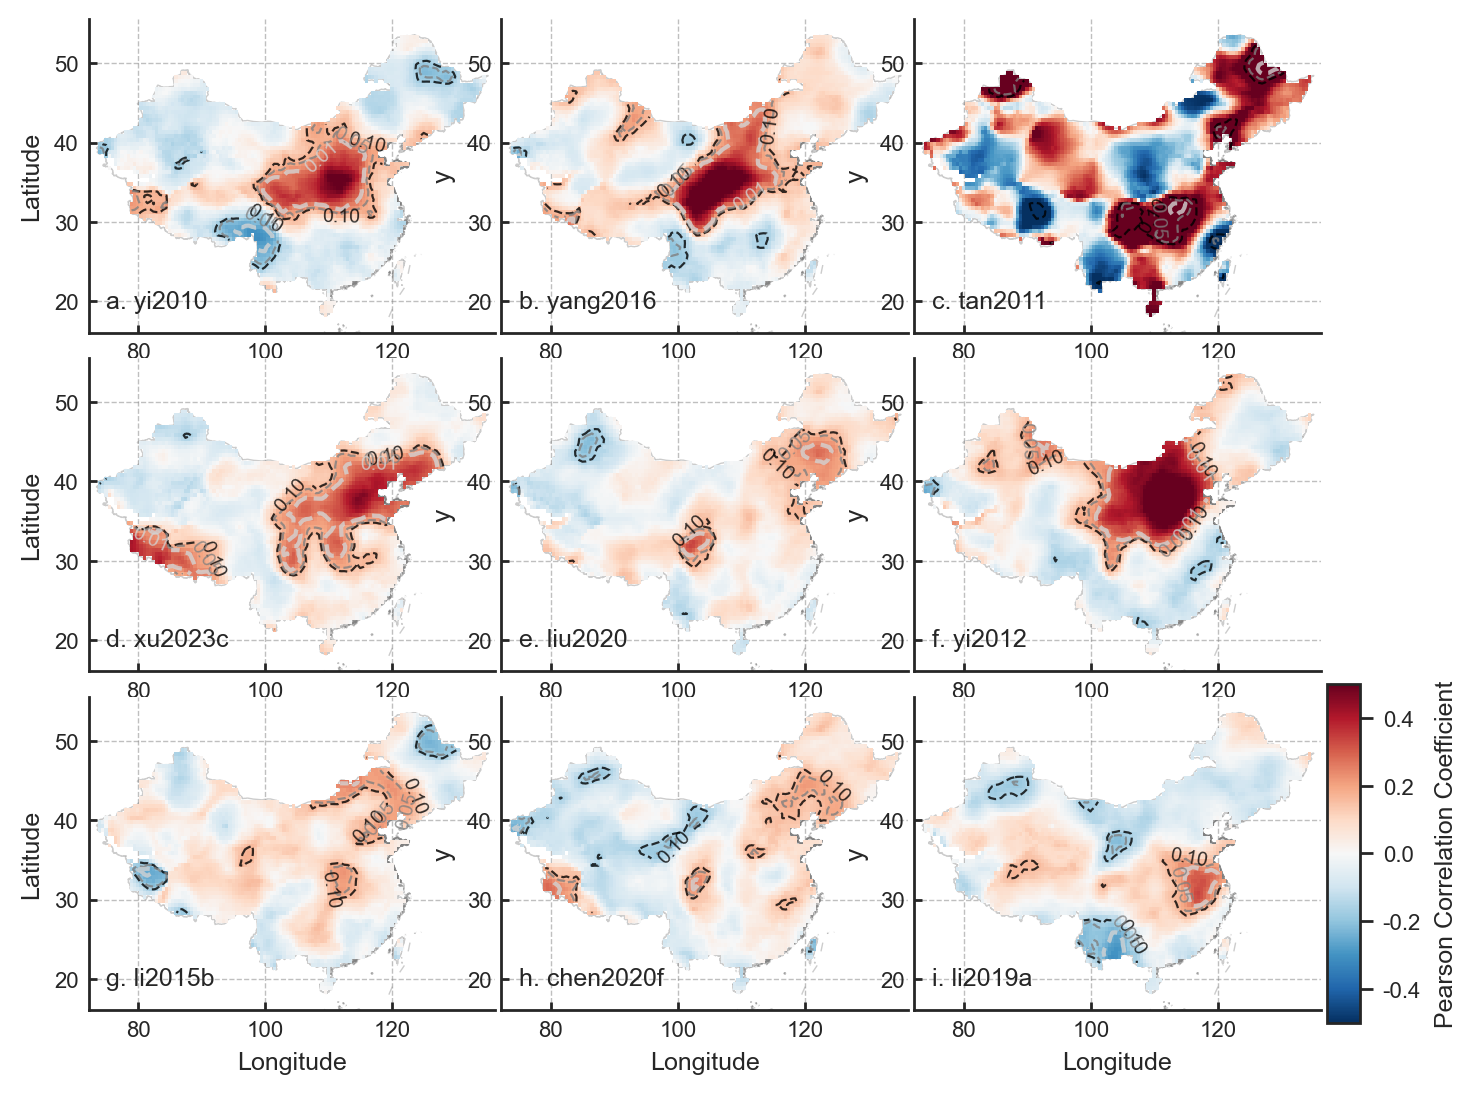

In [8]:
# 更简洁的seaborn风格版本
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as colors

from past1000.utils.plot import plot_corr_map
from past1000.utils.calc import calc_corr
import xarray as xr

# 设置seaborn风格
sns.set_style("ticks")
sns.set_context("paper")


def plot_correlation_maps_seaborn(datasets, summer_precip_z, summer_precip, cfg):
    """使用seaborn风格绘制相关性地图"""

    n_datasets = len(datasets.columns)
    ncols = 3
    nrows = (n_datasets + ncols - 1) // ncols

    # 创建图形和网格 - 为colorbar预留空间
    fig = plt.figure(figsize=(8.2, 2.2 * nrows))
    gs = GridSpec(
        nrows,
        ncols + 1,
        figure=fig,
        hspace=0,
        wspace=0.02,
        width_ratios=[1, 1, 1, 0.08],
    )  # 最后一列给colorbar

    for idx, col in enumerate(datasets.columns):
        row = idx // ncols
        col_idx = idx % ncols

        # 创建子图
        ax = fig.add_subplot(gs[row, col_idx])

        # 计算相关性
        series = datasets[col].to_xarray()
        common_years = np.intersect1d(series.year.values, summer_precip_z.year.values)

        corr = xr.apply_ufunc(
            calc_corr,
            summer_precip_z.sel(year=common_years),
            series.sel(year=common_years),
            input_core_dims=[["year"], ["year"]],
            output_core_dims=[[], [], []],
            vectorize=True,
            output_dtypes=[float, float, int],
        )

        # 绘制地图 - 禁用单个colorbar
        plot_corr_map(
            corr[0],
            corr[1],
            threshold=0.1,
            ax=ax,
            base_maps=cfg.ds.base_maps,
            mask=False,
            crs=summer_precip.rio.crs,
            add_colorbar=False,
        )

        # 设置数据集名称
        label = chr(ord("`") + 1 + idx) + ". " + col
        ax.text(75, 20, label, ha="left", va="center", fontsize=9)

        # seaborn风格的坐标轴设置
        ax.tick_params(labelsize=8, direction="in", length=3)

        # 只在边缘显示标签
        if row == nrows - 1:  # 最后一行
            ax.set_xlabel("Longitude", fontsize=9)
        if col_idx == 0:  # 第一列
            ax.set_ylabel("Latitude", fontsize=9)

    # 添加共享colorbar - 使用简单的mappable方法
    cbar_ax = fig.add_subplot(gs[-1, -1])

    # 创建简单的mappable对象
    norm = colors.Normalize(vmin=-0.5, vmax=0.5)
    sm = cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])

    # 创建colorbar
    cbar = plt.colorbar(
        sm,
        cax=cbar_ax,
        shrink=0.6,
        aspect=20,
        pad=0.1,
    )
    cbar.set_label(
        "Pearson Correlation Coefficient",
        fontsize=9,
        labelpad=5,
    )
    cbar.ax.tick_params(labelsize=8)

    return fig


# 使用seaborn风格
fig = plot_correlation_maps_seaborn(datasets, summer_precip_z, summer_precip, cfg)
plt.show();

### 合成后的数据

In [9]:
from past1000.data import HistoricalRecords

hist = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)
region_gdf = hist.shp.copy()
region_gdf.head()

,name_ch,name_en,region,lon,lat,NAME,省,市,geometry
15,兰州,Lanzhou,华北地区,103.726610,35.181546,临洮县,甘肃省,定西市,POINT (103.72661 35.18155)
16,天水,Tianshui,华北地区,105.600436,34.110788,秦州区,甘肃省,天水市,POINT (105.60044 34.11079)
18,银川,Yinchuan,华北地区,106.135814,37.412291,红寺堡区,宁夏回族自治区,吴忠市,POINT (106.13581 37.41229)
21,榆林,Yulin,华北地区,109.734749,38.066642,横山区,陕西省,榆林市,POINT (109.73475 38.06664)
22,延安,Yan'an,华北地区,109.556290,36.371276,宝塔区,陕西省,延安市,POINT (109.55629 36.37128)


/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_18477/3214788040.py:34: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(loc="upper left")


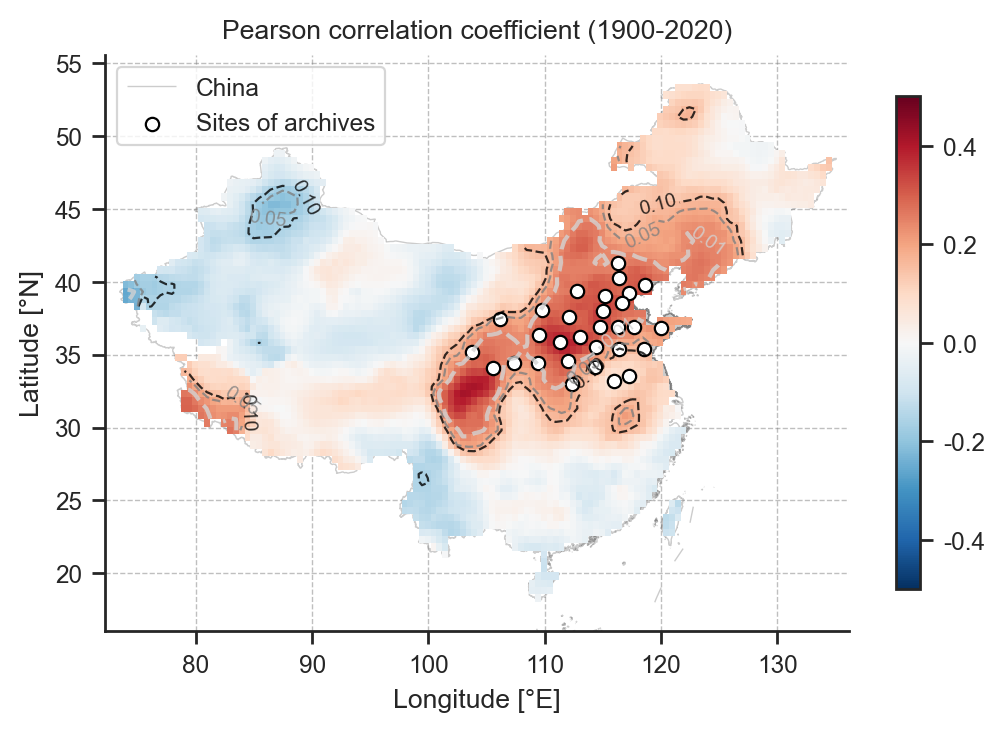

In [10]:
import geopandas as gpd

outline = gpd.read_file(cfg.how.shp)

series = combined["mean"].to_xarray()
common_years = np.intersect1d(series.year.values, summer_precip_z.year.values)
series = combined["mean"].to_xarray()
corr = xr.apply_ufunc(
    calc_corr,
    summer_precip_z.sel(year=common_years),
    series.sel(year=common_years),
    input_core_dims=[["year"], ["year"]],
    output_core_dims=[[], [], []],
    vectorize=True,
    output_dtypes=[float, float, int],
)
ax1 = plot_corr_map(
    corr[0],
    corr[1],
    threshold=0.1,
    mask=False,
    base_maps=cfg.ds.base_maps,
    crs=summer_precip.rio.crs,
)
region_gdf.plot(ax=ax1, color="white", edgecolor="black", label="Sites of archives")
ax1.set_title("Pearson correlation coefficient (1900-2020)")
ax1.set_xlabel("Longitude [°E]")
ax1.set_ylabel("Latitude [°N]")
ax1.legend(loc="upper left")
plt.show();

## 分布测定

最佳分布：Student-t（t）表现最佳：

- 最低sumsquare_error（1.003480），表明直方图拟合最好。
- 较低的AIC（495.670695）和BIC（507.652580），优于lognorm和gamma。
- 最低ks_statistic（0.040494）和最高ks_pvalue（0.5134515），CDF拟合极佳。

次佳分布：lognorm：
- sumsquare_error（1.010543）、AIC（500.570491）、BIC（512.552375）略逊于t。
- ks_statistic（0.040599）和ks_pvalue（0.5101007）与t接近，拟合良好。

In [11]:
from past1000.data import check_distribution
from matplotlib import pyplot as plt


summary = check_distribution(combined["mean"], only_best=False)

summary
print(f"可以看出，对树轮数据的最佳分布拟合是：{summary.index[0]}")

2025-09-07 20:46:15.651 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.176203)
2025-09-07 20:46:15.663 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=0.718998)
2025-09-07 20:46:15.666 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.662848)
2025-09-07 20:46:15.726 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=7.25365)
2025-09-07 20:46:15.760 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.666228)
2025-09-07 20:46:15.767 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.693334)
2025-09-07 20:46:15.770 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=11.196884)
2025-09-07 20:46:15.791 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expo

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.662848,412.289228,422.132544,inf,0.027677,0.411625
t,0.664288,413.862419,428.627394,inf,0.027768,0.407487
lognorm,0.666228,413.131407,427.896381,inf,0.028586,0.371718
gamma,0.693334,412.766250,427.531225,inf,0.034011,0.187067
chi2,0.718998,410.801317,425.566292,inf,0.035454,0.152562


可以看出，对树轮数据的最佳分布拟合是：norm


合并后的数据符合正态分布

### 历史站点分布在哪里

注意这里，先计算每个格点 z-score 再平均，和先计算平均降水，再转化成 z-score 效果是不一样的。我们的目标是得到整个这校验期的指数，所以先平均降水再计算分数比较合理。

<Axes: xlabel='year'>

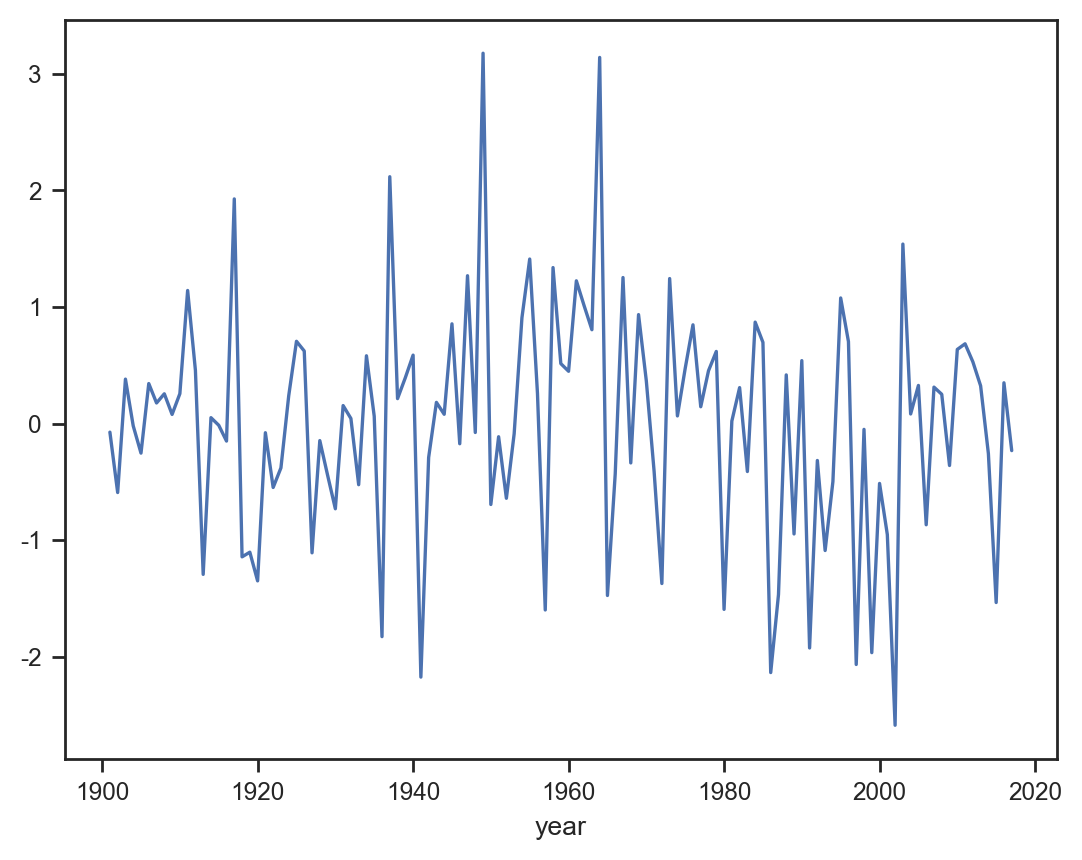

In [ ]:
sel_dict = hist.get_bounds("x", "y")
prec_mean = summer_precip.sel(sel_dict).mean(dim=["x", "y"]).to_series()
prec_z = (prec_mean - prec_mean.mean()) / prec_mean.std()

prec_z.plot()
prec_z.to_csv(cfg.ds.out.precip_z)
print("校验数据导出成功, 路径为:", cfg.ds.out.precip_z)

把每个历史材料站点所在位置的【树轮 v.s. 校验】数据相关性进行记录。

In [13]:
lons = region_gdf.lon.values
lats = region_gdf.lat.values

df = region_gdf[["name_ch", "name_en", "lon", "lat"]].copy()
rs, ps = [], []
for lon, lat in zip(df.lon, df.lat):
    r = corr[0].sel(x=lon, y=lat, method="nearest").item()
    p = corr[1].sel(x=lon, y=lat, method="nearest").item()
    rs.append(r)
    ps.append(p)

df["r"] = rs
df["p"] = ps
df.to_csv("data/region_corr.csv", index=False)
# 相关性
df.head()

,name_ch,name_en,lon,lat,r,p
15,兰州,Lanzhou,103.726610,35.181546,0.246230,0.008565
16,天水,Tianshui,105.600436,34.110788,0.290042,0.001832
18,银川,Yinchuan,106.135814,37.412291,0.209841,0.025699
21,榆林,Yulin,109.734749,38.066642,0.252313,0.007016
22,延安,Yan'an,109.556290,36.371276,0.305594,0.000997


In [14]:
mask = df["p"] < 0.1
n_sig = mask.sum()
print(f"{len(df)} 个站点中，有 {n_sig} 个站点通过了 0.1 显著性水平检验 ({n_sig/len(df):.2%})")

print("相关性描述性统计：")
df[mask]["r"].describe()

30 个站点中，有 27 个站点通过了 0.1 显著性水平检验 (90.00%)
相关性描述性统计：


count    27.000000
mean      0.269985
std       0.055302
min       0.168719
25%       0.231002
50%       0.279488
75%       0.309206
max       0.400575
Name: r, dtype: float64

## 对比自然数据与校验数据

这里我们将展示自然数据的：

- 年值
- 30 年低通滤波
- 上下 1 倍 RMSE 的范围


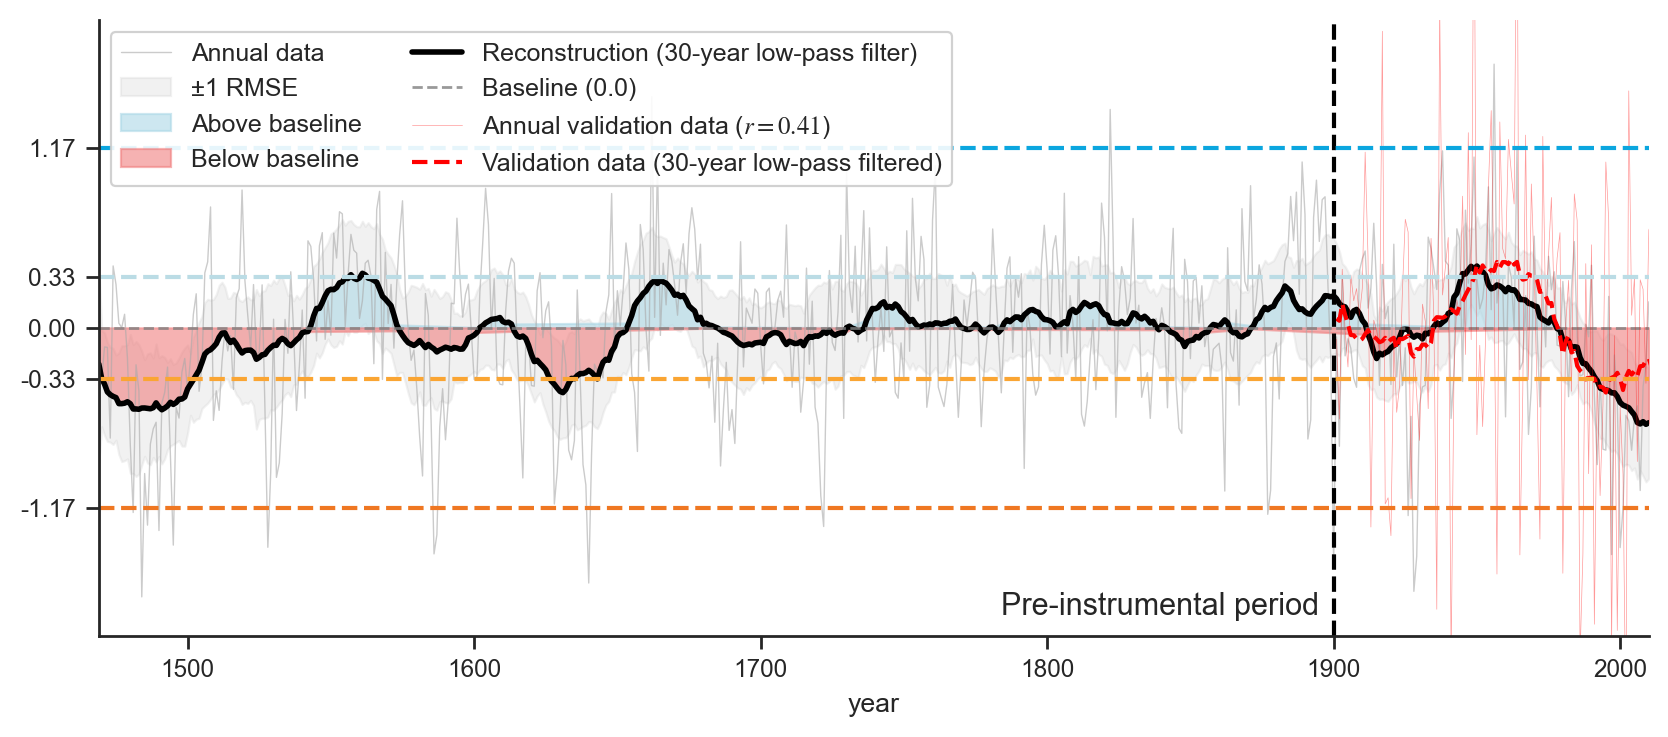

In [15]:
from past1000.utils.plot import plot_time_series_with_lowpass
from past1000.utils.calc import low_pass_filter
from past1000.constants import STAGE1, END, FINAL, THRESHOLDS, COLORS, STD_THRESHOLDS

tree_ring_z = combined["mean"].loc[STAGE1:FINAL]
tree_ring_std = combined["sd"].loc[STAGE1:FINAL]
# 低通滤波
low_pass_cfg = cfg.get("low_pass", {})
mean_pass = low_pass_filter(tree_ring_z, **low_pass_cfg)
prec_z_pass = low_pass_filter(prec_z, **low_pass_cfg)

validation_corr = prec_z.corr(tree_ring_z.loc[END:FINAL])

# 绘制时间序列
ax1 = plot_time_series_with_lowpass(
    data=tree_ring_z,
    filtered_data=mean_pass,
    baseline=0,
    rmse_data=tree_ring_std,
    unit="z-score",
    ylabel="Anormaly of JAS Precipitation",
)
prec_z.plot(
    ax=ax1,
    color="red",
    lw=0.25,
    alpha=0.4,
    label=f"Annual validation data ($r={validation_corr:.2f}$)",
)
prec_z_pass.plot(
    ax=ax1,
    color="red",
    lw=1.5,
    ls="--",
    label="Validation data (30-year low-pass filtered)",
)
ax1.axvline(END, color="black", lw=1.5, ls="--")
ax1.text(END - 5, -1.9, "Pre-instrumental period", ha="right", va="bottom", fontsize=11)

for th, color in zip(THRESHOLDS, COLORS):
    ax1.axhline(th, color=color, lw=1.5, ls="--")
# 设置图例
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=2)
ax1.set_xlim(STAGE1, FINAL)
ax1.set_yticks(STD_THRESHOLDS)
ax1.set_ylim(-2, 2)
ax1.set_title("")

plt.show();

绘制合并后的数据可以看出，在第一个阶段波动更明显；1700 之后的波动没有那么明显。

## 对比历史数据与树轮数据

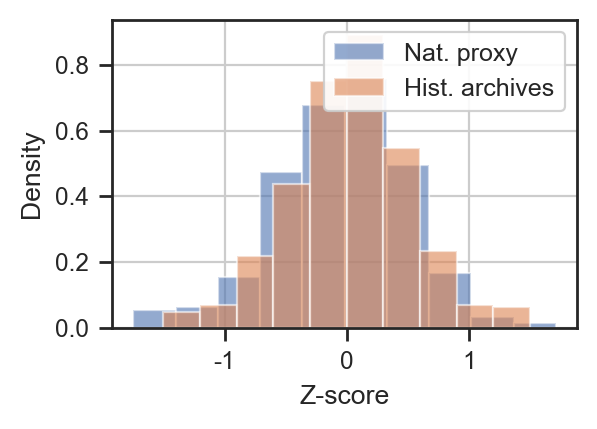

In [16]:
fig, ax1 = plt.subplots(figsize=(3, 2))
tree_ring_z.hist(density=True, alpha=0.6, bins=10, ax=ax1, label="Nat. proxy")

# 历史数据

agg_hist = hist.bayesian_aggregation(spatial_correlation=df["r"])
agg_hist.hist(density=True, alpha=0.6, bins=10, ax=ax1, label="Hist. archives")
ax1.legend(loc="upper right", fontsize=9, framealpha=0.9, ncol=1)
ax1.set_xlabel("Z-score")
ax1.set_ylabel("Density")
ax1.set_title("")
plt.show();

In [17]:
check_distribution(agg_hist, only_best=False)

2025-09-07 20:47:33.762 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=17.269948)
2025-09-07 20:47:33.777 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=3.864346)
2025-09-07 20:47:33.783 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=3.713319)
2025-09-07 20:47:33.785 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=12.044171)
2025-09-07 20:47:33.786 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=8.135372)
2025-09-07 20:47:33.787 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=12.399803)
2025-09-07 20:47:33.791 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=3.716744)
2025-09-07 20:47:33.796 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,3.492472,352.691405,364.854723,inf,0.025518,0.937541
norm,3.713319,348.495795,356.604674,inf,0.038861,0.527940
gamma,3.716744,350.644865,362.808183,inf,0.038211,0.549684
lognorm,3.718147,351.399632,363.562950,inf,0.037104,0.587397
chi2,3.864346,352.285917,364.449235,inf,0.043497,0.384830


## 最终作图

图 1 我希望包括以下内容：

- 证明对数论数据的拟合效果不错
- 证明历史数据和数论数据都能在基本的旱涝历史上达到一致
- 证明空间上有代表性
- 证明历史判断比树轮的判断更极端

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_18477/1138716799.py:89: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax3.legend(loc='upper left', fontsize=9, framealpha=0.9, ncol=1)


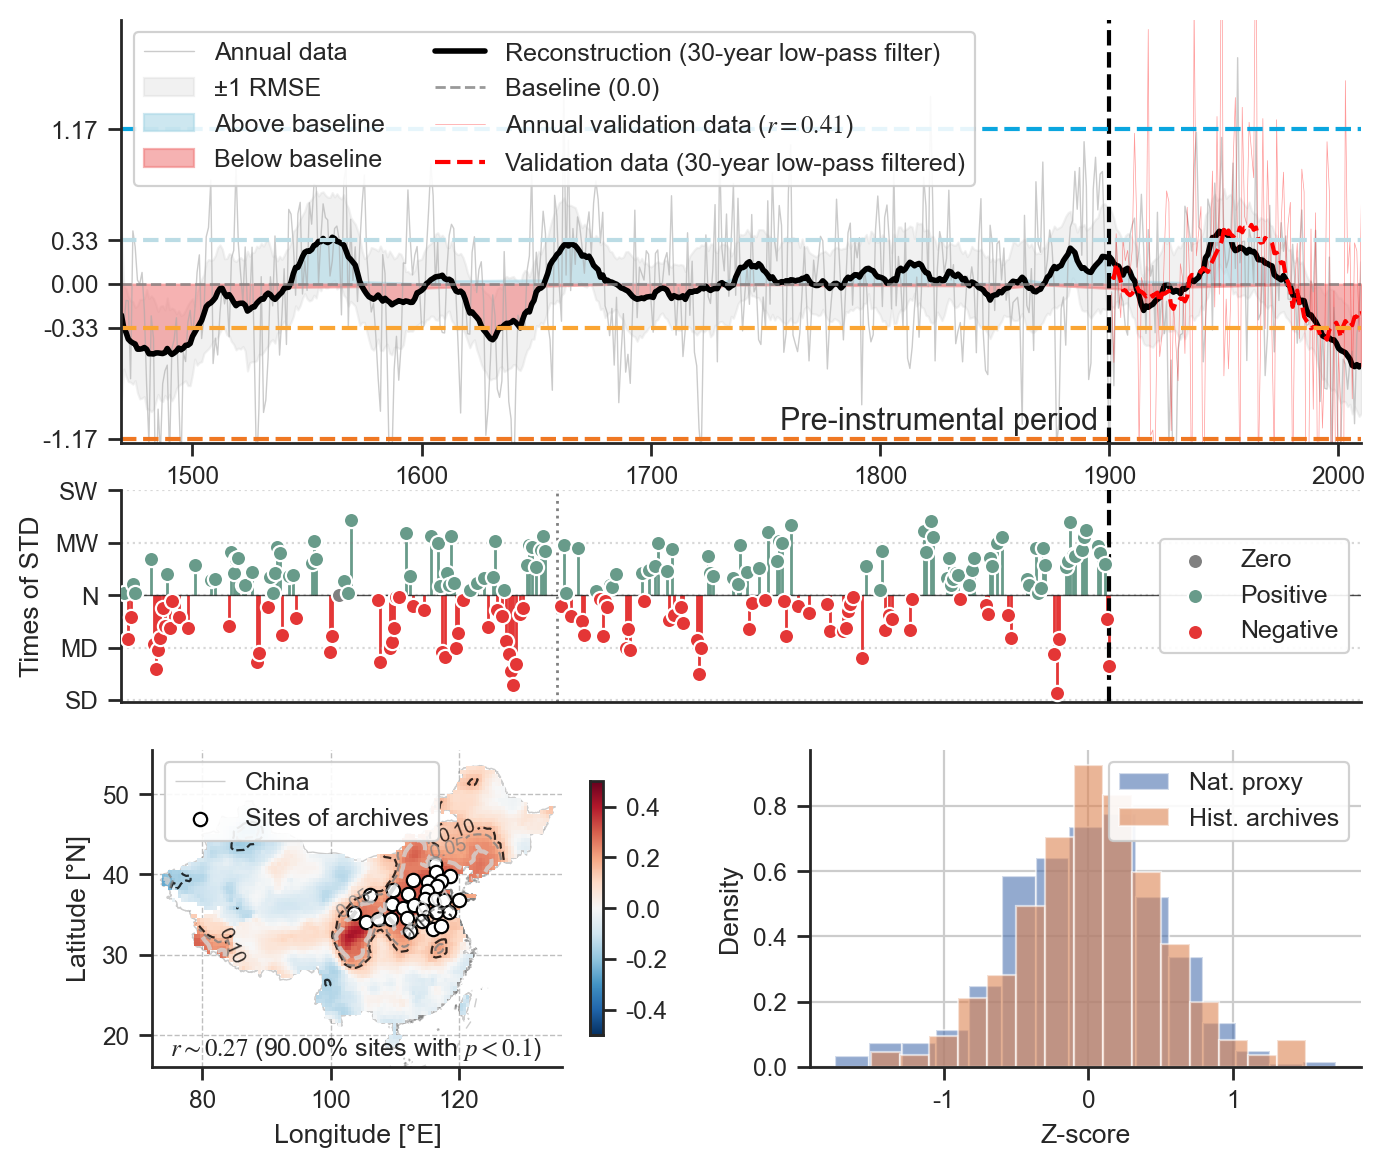

In [21]:
from past1000.utils.plot import plot_std_times
from past1000.constants import TICK_LABELS, STAGE2
from past1000.data import HistoricalRecords

fig = plt.figure(figsize=(8, 6.8), constrained_layout=False)
gs = fig.add_gridspec(
    3,
    2,
    hspace=0.15,
    wspace=0.25,
    width_ratios=[1, 1],
    height_ratios=[2, 1, 1.5],
)

# ================================================
# 自然数据
ax1 = fig.add_subplot(gs[0, :])

# 绘制时间序列
ax1 = plot_time_series_with_lowpass(
    data=tree_ring_z,
    filtered_data=mean_pass,
    baseline=0,
    rmse_data=tree_ring_std,
    ylabel="JAS Precipitation Anormaly",
    ax=ax1,
)
prec_z.plot(
    ax=ax1,
    color="red",
    lw=0.25,
    alpha=0.4,
    label=f"Annual validation data ($r={validation_corr:.2f}$)",
)
prec_z_pass.plot(
    ax=ax1,
    color="red",
    lw=1.5,
    ls="--",
    label="Validation data (30-year low-pass filtered)",
)
ax1.axvline(END, color="black", lw=1.5, ls="--")
ax1.text(
    END - 5, -1.15, "Pre-instrumental period", ha="right", va="bottom", fontsize=11
)

for th, color in zip(THRESHOLDS, COLORS):
    ax1.axhline(th, color=color, lw=1.5, ls="--")
# 设置图例
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=2)
ax1.set_xlim(STAGE1, FINAL)
ax1.set_yticks(STD_THRESHOLDS)
ax1.set_ylim(-1.2, 2)
ax1.set_title("")

# ================================================
# 历史数据
# 绘制历史数据，看看哪些年份有记录
ax2 = fig.add_subplot(gs[1, :])

history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)

data = history.aggregate(to_int=False).loc[STAGE1:END]

ax2 = plot_std_times(data, ax=ax2, zorder=-1)
ax2.set_yticks(np.arange(-2, 2.1, 1))
ax2.set_xlim(STAGE1, FINAL)
ax2.set_yticklabels(TICK_LABELS)
ax2.axvline(END, color="black", lw=1.5, ls="--")
ax2.axvline(STAGE2, color="gray", lw=1, ls=":")
ax2.legend(loc="center right", fontsize=9, framealpha=0.9, ncol=1)

# ================================================
# 空间分布
ax3 = fig.add_subplot(gs[2, 0])
ax3 = plot_corr_map(
    corr[0],
    corr[1],
    threshold=0.1,
    mask=False,
    base_maps=cfg.ds.base_maps,
    crs=summer_precip.rio.crs,
    ax=ax3,
)
region_gdf.plot(ax=ax3, color="white", edgecolor="black", label="Sites of archives")
ax3.set_xlabel("Longitude [°E]")
ax3.set_ylabel("Latitude [°N]")
ax3.text(
    75,
    20,
    f'$r\sim{df[mask]["r"].mean():.2f}$ ({mask.sum()/len(df):.2%} sites with $p<0.1$)',
    ha="left",
    va="top",
    fontsize=9,
)
ax3.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)

## ================================================
BINS = 15
ax4 = fig.add_subplot(gs[2, 1])
tree_ring_z.hist(density=True, alpha=0.6, bins=BINS, ax=ax4, label="Nat. proxy")
agg_hist.hist(density=True, alpha=0.6, bins=BINS, ax=ax4, label="Hist. archives")
ax4.set_ylabel("Density")
ax4.set_xlabel("Z-score")
ax4.legend(loc="upper right", fontsize=9, framealpha=0.9, ncol=1)

# ================================================
# 设置整体作图的样式
for ax in fig.axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
ax2.get_xaxis().set_visible(False)
plt.show();